<a href="https://colab.research.google.com/github/AndreasMing/Learning/blob/main/NN_Makemore/NeuralnetsWithMakemore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducing PyTorch
This is a Notebook by [Andreas Ming](https://github.com/AndreasMing) to the free lecture [The spelled-out intro to language modeling: building makemore](https://www.youtube.com/watch?v=PaCmpygFfXo) and [The spelled-out intro to language modeling: building makemore. Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I) by [Andrey Karpathy](https://github.com/karpathy).

In this lecture a [bigram](https://towardsdatascience.com/implementing-a-character-level-trigram-language-model-from-scratch-in-python-27ca0e1c3c3f) (one character predicts the next one) character-level language model will be implemented. The focus is set on (1) introducing ``torch.Tensor`` and its subtleties and use in efficiently evaluating neural networks as well as (2) the overall framework of language modeling that includes model training, smpling and the evaluation of a loss.

In the second lecture we implement a multi layer perceptron (MLP) character level language model. Furthermore we will introduce basics of machine learning (e.g. model training, learning rate tuning, hyperparameters, evaluation, train/dev/test splits, under/overfitting, etc.).

## The Dataset
The dataset contains around 32k different names. In theorie every given name gives a little bit more data on which character can be followed by which and what character is likely to end a name for example. 

In [1]:
!wget https://raw.githubusercontent.com/AndreasMing/Learning/main/NN_Makemore/MakemoreNames.txt
words =  open('MakemoreNames.txt', 'r').read().splitlines()   # Import words into a python list

--2022-09-16 14:51:56--  https://raw.githubusercontent.com/AndreasMing/Learning/main/NN_Makemore/MakemoreNames.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘MakemoreNames.txt’

MakemoreNames.txt   100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2022-09-16 14:51:57 (8.57 MB/s) - ‘MakemoreNames.txt’ saved [228145/228145]



In [2]:
print(words[:10])
print('dataset lenght:', len(words))
print('shortest word:', min(len(w) for w in words), 'char')
print('longest word:', max(len(w) for w in words), 'char')

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
dataset lenght: 32033
shortest word: 2 char
longest word: 15 char


## Bigrams in the dataset

In [3]:
# Show bigrams in the dataset
for w in words[:3]:
    chs = ['<S>'] + list(w) + ['<E>\n']     # Encapsulates every word by a Start <S> and an End <E> character
    for ch1, ch2 in zip(chs, chs[1:]):      # zipps up a character by the following one  # print(list(zip(w, w[1:])))
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>

<S> o
o l
l i
i v
v i
i a
a <E>

<S> a
a v
v a
a <E>



## Counting bigrams in a python dictionary

In [4]:
b = {}  # dictionary to count bigrams
for w in words[:]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)                # temp bigrams
        b[bigram] = b.get(bigram, 0) + 1   # map bigram to its appearances
        
# sorted(b.items(), key = lambda kv: -kv[1]) # show key values sorted by value

## Counting bigrams in a 2D ``torch.Tensor``

In [5]:
import torch

In [6]:
N = torch.zeros((27, 27), dtype = torch.int32)   # Initialize a array for a 2D Data analysis (26 char + 1 special char)

In [7]:
# character lookup table
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

In [8]:
# crate statistics in 2D Tensor
for w in words[:]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

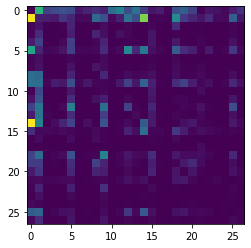

In [9]:
# simple visualisation
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(N)

(-0.5, 26.5, 26.5, -0.5)

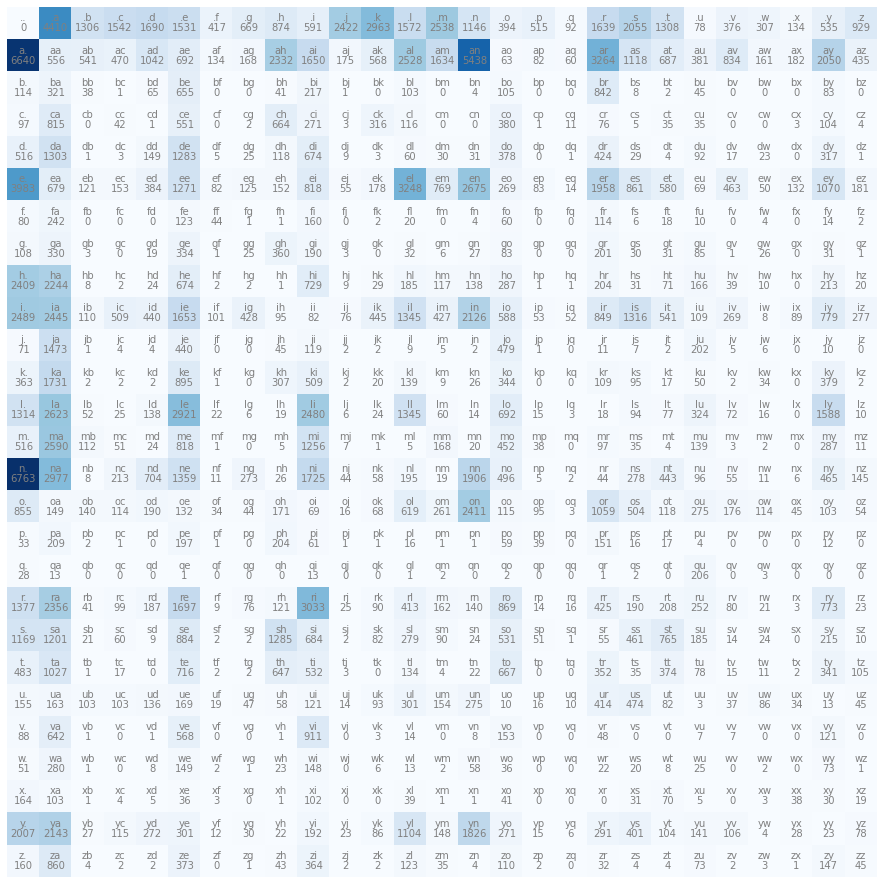

In [10]:
# much nicer visualisation
itos = {i:s for s, i in stoi.items()}         # transpond array
plt.figure(figsize = (16,16))
plt.imshow(N, cmap = 'Blues')                 # plot image

for i in range(27):                           # iterate the text over every cell
  for j in range(27):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off')

## Sampling from the model

### ``torch.multinomial``

[Multinomial](https://pytorch.org/docs/stable/generated/torch.multinomial.html) distribution describes the probability of a outcome.

**Example:** Three card players play a series of matches. The probability that player A will win any game is 20%, the probability that player B will win is 30%, and the probability player C will win is 50%. If they play 6 games, what is the probability that player A will win 1 game, player B will win 2 games, and player C will win 3?

In [11]:
g = torch.Generator().manual_seed(2147483647)     # define seed for random generator
p = torch.rand(3, generator = g)                  # outcome will always be the same because of the seed
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [12]:
torch.multinomial(p, num_samples=20, replacement=True, generator=g)   # describes probability of a outcome
                                                                      # 60% 0, 30% 1, 10% 2

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

### ``torch.multinomial`` on dataset

In [13]:
p = N[0].float()      # take first row of N and convert to floating point
p = p / p.sum()       # normalise
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [14]:
g = torch.Generator().manual_seed(2147483647)     # define seed for random generator
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'm'

As we can see the character *m* was chosen "randomly" from our dataset according to our statistics on the appearance of characters at the beginning of a word (row 0). As can seen on the [plot above](https://colab.research.google.com/github/AndreasMing/Learning/blob/main/NeuralnetsWithMakemore.ipynb#scrollTo=MCL7Ioaqdy_Y&line=9&uniqifier=1) *m* is one of the most likely characters to start a name, thus implying our statistics are correct.

In the next step we go to the *m*-row, work out the probability of a following character and ``torch.multinomial`` will give us one by "random". This process is then repeated until the name is finished.

In [15]:
g = torch.Generator().manual_seed(2147483647)     # define seed for random generator

for i in range(10):
  out = []
  ix = 0                                            # start token
  while True:
    p = N[ix].float()     # sample row
    p = p / p.sum()       # normalise
    #p = torch.ones(27) / 27.0         # test to see if there is any training

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()   # get "random" letter by probability
    out.append(itos[ix])
    if ix == 0:           # index is at the namebeginning again
      break
  print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.


As we can see we only get a ton of nonsense names. That is because we are only using a model which is trained on bigram. By this it only nows what character is likely to follow another. It doesn't even have a sense on where we are in the name and by this we get mini and gigantic names.


## Efficiency!

## Vectorized normalization of the rows
In the above code we sample and normalize from the dataset in each loop. This can be done better. So in the following code we normalise each row with the sum of itself.

For this we use the [``torch.sum()``](https://pytorch.org/docs/stable/generated/torch.sum.html?highlight=sum#torch.sum) function. We must keep the dimension for futher processing and we have to use ``dim`` $= 1$ for it to sum up each row. This will place the sums of each row in a $27$x$1$ vector.

To devide each element of each row by the rows sum we use [boradcasting](https://pytorch.org/docs/stable/notes/broadcasting.html?highlight=broadcasting) which extends the 27x1 matrix to a 27x27 matrix and devides elementwise.


## Broadcasting
Keep in mind the basic rules of broadcasting when the dimensions of the matricies don't correspond:
* Each tensor has at least one dimension.
* When iterating over the dimension sizes, starting at the trailing dimension, the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

In [16]:
P = (N+1).float()                 # model smoothing and convert whole array to float
Psum = P.sum(1, keepdim=True)     # sum every row and put it in a 27x1 Vector
P /= Psum                         # normalised matrix
P[0].sum()                        # check sum (must be 1)

tensor(1.)

In [17]:
g = torch.Generator().manual_seed(2147483647)     # define seed for random generator

for i in range(10):
  out = []
  ix = 0                                            # start token
  while True:
    p = P[ix]       # take from normalized matrix

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()   # get "random" letter by probability
    out.append(itos[ix])
    if ix == 0:           # index is at the namebeginning again
      break
  print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.


## Loss Function
Now we want to summarize the quality of our model into a single number, called the loss. First off we take out the likelyhood directly from our normalized dataset, the product of which would corresponds to the [likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). For the sake of convenience we work with the *log likelihood* because $log(a*b*c) = log(a) + log(b) + log(c)$.

Now ``log_likelihood`` is from $-∞$ to $0$ but in the process of training we talk about "lowering the loss", that is why we negate ``log_likelihood`` to get the negative loss likelihood or ``nll``. To get the value a respect to the samples we divide ``nll`` by the amount of samples.

### Goal of training
> * maximize likelihood of the data w.r.t. model parameters (statistical modeling)
> * equivalent to maximizing the log likelihood (because log is monotonic)
> * equivalent to minimizing the negative log likelihood
> * equivalent to minimizing the average negative log likelihood

In [18]:
# evaluate the quality of the model
log_likelihood = 0.0
n = 0

for w in ['hanjq']:   # check sample names
#for w in words[:]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]          # the product of these values gives us the likelihood (0 to 1, 1 is best)
        logprob = torch.log(prob)   # the sum of these values gives ud the log likelihood (-inf to 0, 0 is best)
        log_likelihood += logprob
        n += 1                      # for averageing the likelihood
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'\nlog likelihood: {log_likelihood:.4f}')
nll = -log_likelihood               # negative log likelihood --> single number of quality (the lower, the better)
print(f'nll: {nll:.4f}')
print(f'average nll: {nll/n:.4f}')


log likelihood: -22.9822
nll: 22.9822
average nll: 3.8304


# The neural network approach

We now have seen how modeling can be done by simple statistical methods. In a next step we want to take a different approach, casting the problem of bigram character level language modelling into a neural network framework. In a neural nework framework we approach things very differently, but we will end up in a very similar spot.

The very basic architecture will be a character as an input and another character as an output. With gradient training we then want to tune the network to always have a low *negative log likelihood* acccording to the distributions we made out in the dataset above.

## Create the bigram trainingset


In [19]:
# trainingset bigram (x,y)
xs, ys = [], []                 # inputs x and outputs y

for w in words[:]:             # set number of examples
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)           # convert lists to tensors
ys = torch.tensor(ys)
num = xs.nelement()
print(f'number of examples: {num}')

number of examples: 228146


From the above example with the first name emma we get as an output:
```
xs
>>> tensor([ 0,  5, 13, 13,  1])
ys
>>> tensor([ 5, 13, 13,  1,  0])
```
So for the ``0`` is followed by ``5`` etc.

## One-hot encoding
It is not recomended to feed the above mentioned Integers directly into a neural network. But they can be encoded into a vector, this is called [**one-hot encoding**](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html).

In [20]:
import torch.nn.functional as F       # common way of import

In [21]:
xenc = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encode to !FLOAT!

xenc: tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]]) 
 shape: torch.Size([228146, 27])


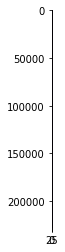

In [22]:
print(f'xenc: {xenc} \n shape: {xenc.shape}')
plt.imshow(xenc)

## The neural net

### One layer with matrix multiplication
In this first example we feed in all the 5 inputs from ``xenc`` simoultaniously into one neuron and multiply it by random set weights. So it computed $wx+b$ in parallel for all inputs, with $b=0$.

In [23]:
W = torch.randn((27, 1))  # random weights according to normal distribution (Gaussche Glockenkurve)
xenc @ W                  # matrix multiplication w*x # (5, 27) @ (27, 1) -> (5, 1)

tensor([[ 0.6116],
        [ 0.1734],
        [ 0.4513],
        ...,
        [ 0.6909],
        [-0.3414],
        [-1.2347]])

In the next example we want this to happen into 27 input neurons. With the next example we evaluate in parallel all 27 neurons on all 5 inputs.

This will tell us the firing-rate of all the 27 input neurons on the 5 examples.

In [24]:
W = torch.randn((27, 27))   # random weights according to normal distribution (Gaussche Glockenkurve)
xenc @ W                    # matrix multiplication w*x # (5, 27) @ (27, 1) -> (5, 27)

tensor([[-1.0009, -0.1296,  0.5407,  ...,  0.1561, -0.4752, -0.5424],
        [ 0.4955, -2.0624, -0.4887,  ...,  0.4310,  0.7291,  0.8653],
        [-0.8165, -1.2454, -0.5209,  ..., -0.0666, -0.2729, -1.0778],
        ...,
        [-1.4812,  1.7075, -0.3646,  ..., -0.9845,  0.0727,  0.2265],
        [ 1.8484,  0.0214, -0.4028,  ..., -0.3200, -0.4634, -1.4016],
        [ 0.3771,  0.1954, -0.1426,  ...,  1.5201, -0.7976,  1.2699]])

In this example we will only use a simple one linear layer neural net without any bias or non linearity (eg. tanh). In the end we want a equivalent output of the neural net as we had with the normalized dataset ``N`` above.

* First  we exponentiate ``.exp()`` all the values, negative values will be $0$ to $<1$ and positive values will be $\geq1$. So called **log-counts**
* Next we normalize the vectors to get the **probabilities**

These probabilities can now be interpreted the same as the dataset ``N`` above and all the operations are differentiable, so that we can backpropagate through.

In [25]:
logits = xenc @ W       # predicted log-counts

# softmax
counts = logits.exp()   # equivalent to dataset N
probs = counts / counts.sum(1, keepdims=True)  # normalize probabilities for next character


### Softmax
These last two lines [of code](https://colab.research.google.com/github/AndreasMing/Learning/blob/main/NeuralnetsWithMakemore.ipynb#scrollTo=Ac_ym90fHZGd&line=1&uniqifier=1) are a so called **softmax** activation function. The input is often a output layer of a nn and the output will give a normalized probability of these output neurons fireing.
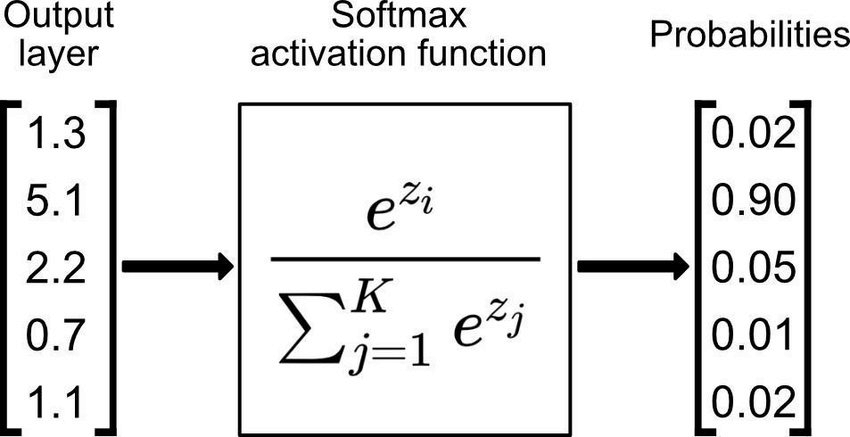

# Training the Network
First of we will summarize what we have done above. Next up we will train the network based on the principles we learned in the lecture of [micrograd](https://github.com/AndreasMing/Learning/blob/main/NN_Micrograd/NeuralnetsWithMicrograd.ipynb).

## Summary

For dataset construction look [here](https://colab.research.google.com/github/AndreasMing/Learning/blob/main/NeuralnetsWithMakemore.ipynb#scrollTo=jFEP5drB1mO4&line=14&uniqifier=1).

In [26]:
# randomly initialze 27 neuron weights. Each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)   # seeded generator for tutorial purposes
W = torch.randn((27, 27), generator=g)          # random weights according to normal distribution (Gaussche Glockenkurve)

In [27]:
xenc = F.one_hot(xs, num_classes=27).float()    # input to the network: one-hot encode to !FLOAT!
logits = xenc @ W                               # predicted log-counts
# softmax
counts = logits.exp()                           # equivalent to dataset N
probs = counts / counts.sum(1, keepdims=True)   # normalize probabilities for next character

In [28]:
nlls = torch.zeros(5)                           # initialize negative log likelihood
for i in range(2):
  # bigram:
  x = xs[i].item()    # input char
  y = ys[i].item()    # output char
  print('-------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes: {x},{y})')
  print('input to neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (true next char):', y)
  p = probs[i, y]
  print('probabilty evaluated by the nn:', probs[i])
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=====')
print('average nll (=loss):', nlls.mean().item())

-------
bigram example 1: .e (indexes: 0,5)
input to neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (true next char): 5
probabilty evaluated by the nn: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
-------
bigram example 2: em (indexes: 5,13)
input to neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
   

## Gradient descent training

For dataset construction look [here](https://colab.research.google.com/github/AndreasMing/Learning/blob/main/NeuralnetsWithMakemore.ipynb#scrollTo=jFEP5drB1mO4&line=14&uniqifier=1).

In [29]:
# randomly initialze 27 neuron weights. Each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)   # seeded generator for tutorial purposes
W = torch.randn((27, 27), generator=g, requires_grad=True)   # random weights according to normal distribution (Gaussche Glockenkurve)
loop = 0

In [30]:
print(f'number of training bigrams: {num}')
print('loop:\tloss:')
# gradient descent
for k in range(5):
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float()            # input to the network: one-hot encode to !FLOAT!
  logits = xenc @ W                                       # predicted log-counts
  counts = logits.exp()                                   # [softmax] equivalent to dataset N
  probs = counts / counts.sum(1, keepdims=True)           # [softmax] normalize probabilities for next character
  loss = (-probs[torch.arange(num), ys].log().mean()      # loss (negative log likelihood)
          + 0.01 * (W**2).mean())                         # regularization (trying to make all ws zero)

  loop +=1
  print(f'{loop}\t{loss.item()}')

  # backward pass
  W.grad = None       # set gradient to zero
  loss.backward()     # backpropagation

  # weight update
  W.data += -50 * W.grad

number of training bigrams: 228146
loop:	loss:
1	3.7686190605163574
2	3.3788065910339355
3	3.16109037399292
4	3.0271859169006348
5	2.9344842433929443


## Sampling from Network

In [31]:
# sample from neural net model
for i in range(10):
  out = []
  ix = 0                                            # start token
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W                                       # predicted log-counts
    counts = logits.exp()                                   # [softmax] equivalent to dataset N
    p = counts / counts.sum(1, keepdims=True)
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()   # get "random" letter by probability
    out.append(itos[ix])
    if ix == 0:           # index is at the namebeginning again
      break
  print(''.join(out))

bpxhararlw.
tpjanzriliut.
asuqyvn.
evkda.
na.
jqfxceajszvkstgdarh.
.
gmhui.
wajglpriafdllltc.
mamhduus.


As we can see we get the exact same output as with the datadriven model above, but with a completly different approach.

# MLP language character-level language model
This is the second part of the building of makemore and is based on the lecture [The spelled-out intro to language modeling: building makemore. Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I).

First we have a look at the [Bengio et al. 2003 MLP language model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) paper. They work with a vocabulary of 17k words, from which they build their *word*-level language model. We will use a *character*-level language model, but we'll use the same architecture.

To work with the words, they put every word in a *(eg.)* 30 dimensional vector, so they will end up with 17k datapoints in a 30 dimensional vectorspace. Over training vectors of familiar words will get close, vectors of synonyms will fully align and vectors of opposites will deiverge from each other *(See following Picture)*.

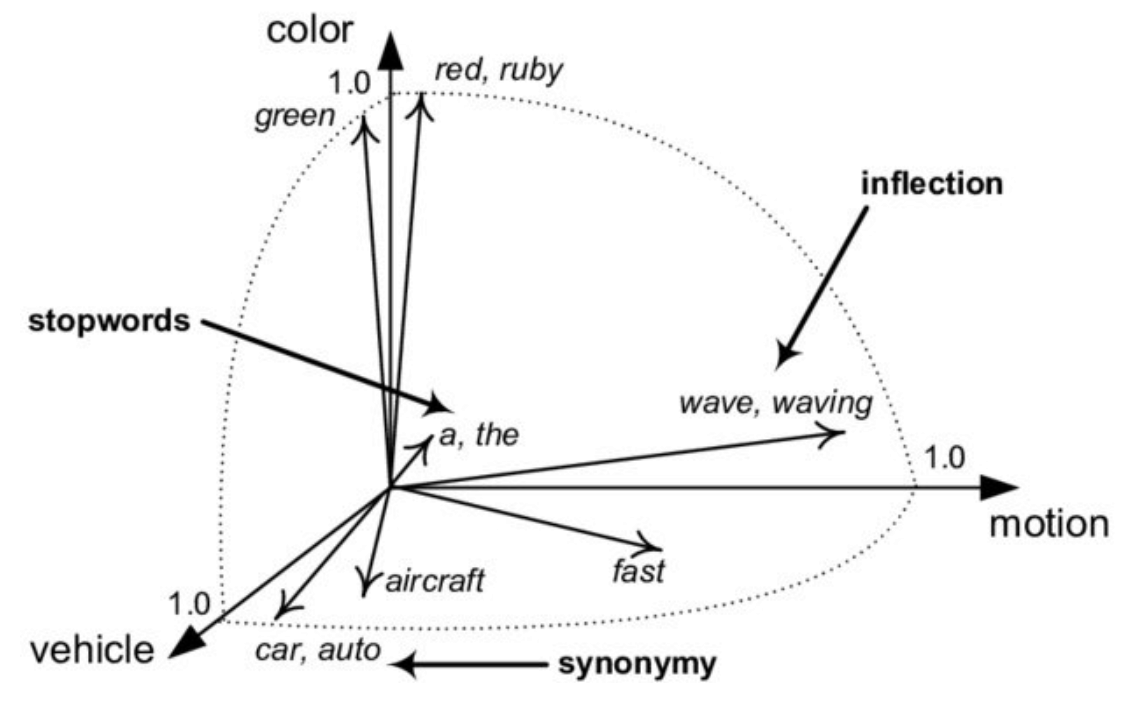


We use the same architecure for our character-level language model as they used for the word-level language model. Basically we will have 30 input neurons for the number of dimensions of our vector space. Next we have a hidden layer (size is up to the designer --> hyperparameter) which all are fully connected to all input neurons. On the output layer we have 27 neurons for all output characters which are all connected to all hidden neurons. So we have 27 logits here which are topped up with a softmax layer, so that we have a nice probability distribution for the next character in the sequence.

During training we have the lable of the next character and we are maximiseing the probability of that character with respect to the parameters (weights, biases, look-up-table) of this neural net using backpropagation.

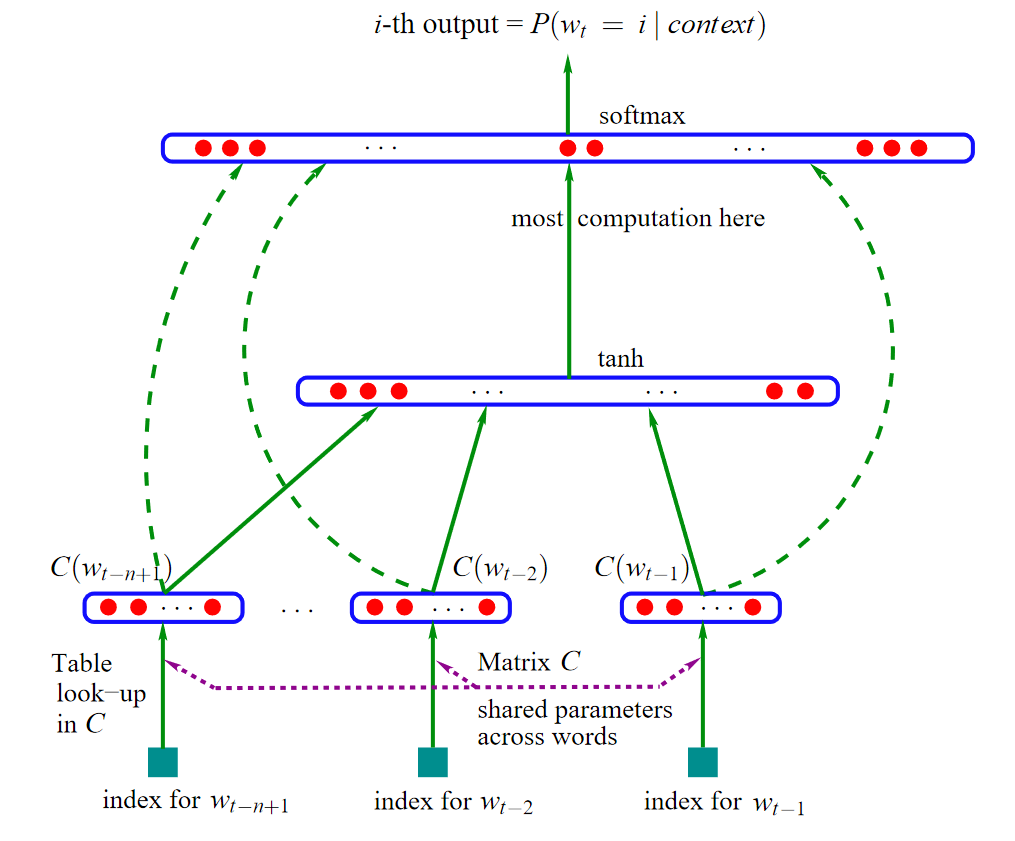

## (re)building dataset
Taking the wordlist from above.

In [77]:
# build dataset
block_size = 3          # number of characters used to predict the next one
X, Y = [], []           # X: Input to the neural net, Y: Label for each example in X

for w in words[:]:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]    # crop and append "rolling window"

X = torch.tensor(X)
Y = torch.tensor(Y)

In [78]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

## implement embedding look-up-table

In [34]:
C = torch.randn((27, 2))    # size of embedding: 2

Now there are two ways of embedding the integers:
```
C[5]
>>> tensor([ 0.0657, -0.9301])

F.one_hot(torch.tensor(5), num_classes=27).float() @ C
>>> tensor([ 0.0657, -0.9301])
```
As we can see we get the exact same result, because with one-hot wie get a matrix multiplication with a matrix with only one 1, so it's the same as indexing this in ``C`` directly.

In [35]:
emb = C[X]      # embedding of integers (32, 3, 2)

## implementing neural net
The neural net is implemented according to the architecture mentioned by the [Bengio et al. 2003 MLP language model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) paper.

In [ ]:
# hidden layer of nn
W1 = torch.randn(6, 100)      # number of inputs (3 char x 2 dim embedding = 6), hyperparameter 100 neurons
b1 = torch.randn(100)

Check out a short side note on [PyTorch internals](http://blog.ezyang.com/2019/05/pytorch-internals/) on how Tensors are stored in memory.

The following expression is good to know:
```
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)
```
Also see [``torch.cat``](https://pytorch.org/docs/stable/generated/torch.cat.html) and [``torch.unbind``](https://pytorch.org/docs/stable/generated/torch.unbind.html).

In [36]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)       # hidden layer of activations -> 100 dimensional activation for all examples

In [46]:
# output layer of nn
W2 = torch.randn(100, 27)     # 27 output neurons for every char
b2 = torch.randn(27)

# number of parameters
print('number of parameters:', sum(p.nelement() for p in [C, W1, b1, W2, b2]))

logits = h @ W2 + b2 
# softmax   
counts = logits.exp()           # fake counts
prob = counts / counts.sum(1, keepdims=True)    # normalize into probability

#loss
loss = -prob[torch.arange(32), Y].log().mean()   # negative log likelihood
print('loss: ', loss)

number of parameters: 3481
loss:  tensor(13.2957)


## ``F.cross_entropy()``
The calculation of the loss with softmax can be done much more efficiently with ``F.cross_entropy(logits, Y)`` (also [see](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html?highlight=cross_entropy#torch.nn.functional.cross_entropy)) and it will compute the same loss as 
```   
counts = logits.exp()           # fake counts
prob = counts / counts.sum(1, keepdims=True)    # normalize into probability
loss = -prob[torch.arange(32), Y].log().mean()   # negative log likelihood
```

There are two reasons for it to be more efficient:
1. It will cluster up the calculations performed, which will lead to less memory used and a easier backward pass
2. The ``.exp()`` function will run into memory problems with really large *logits*. ``.cross_entropy()`` will handle this problem. [see](https://youtu.be/TCH_1BHY58I?t=2104)



In [45]:
F.cross_entropy(logits, Y)

tensor(18.9445)

## Training the network
When we only use 32 examples (here ~5 words), but we have ~8000 parameters, we talk about **overfitting**.

In [135]:
# Set up nn
g = torch.Generator().manual_seed(2147483647)
loop = 0

# embedded look up
C = torch.randn((27, 2), generator=g, requires_grad=True)

# hidden layer of nn
W1 = torch.randn((6, 100), generator=g, requires_grad=True)   # number of inputs (3 char x 2 dim embedding = 6), hyperparameter 100 neurons
b1 = torch.randn(100, requires_grad=True)

# output layer of nn
W2 = torch.randn((100, 27), generator=g, requires_grad=True)  # 27 output neurons for every char
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [144]:
print('loop:\tloss:')

for _ in range(5):
  # forward pass
  emb = C[X]                                  # input layer 
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
  logits = h @ W2 + b2                        # output layer
  loss = F.cross_entropy(logits, Y)

  print(loop, '\t', loss.item())
  loop += 1
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad


loop:	loss:
40000 	 2.3148703575134277
40001 	 2.3125362396240234
40002 	 2.311438798904419
40003 	 2.310798168182373
40004 	 2.3103671073913574


### using mini batches
Because iterating over the whole dataset needs alot of processing for forward- and backwardpassing, we can also iterate over so called **mini batches**. With this we train the model only with a portion of the whole dataset.

> Because we only handle minibatches, the quality of the gradient is much lower.

But it is more efficient to use a approximate gradient and just make more steps, than evaluating a exact gradient and take fewer steps.

In [84]:
torch.randint(0, X.shape[0], (32,))

tensor([107382, 101031, 213921, 136044, 207438, 163923, 209696, 166722, 163639,
        223382, 203803, 116078, 175386, 220355, 107554, 175329,  88384, 153158,
        138858,  17192, 172995, 207030,  74337,  50356, 184461, 219856,  80538,
         66536,  14970, 122838, 170209,  32337])

In [142]:
print('loop:\tloss:')

for _ in range(10000):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))
  # forward pass
  emb = C[X[ix]]                                  # input layer 
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
  logits = h @ W2 + b2                        # output layer
  loss = F.cross_entropy(logits, Y[ix])

  #print(loop, '\t', loss.item())
  loop += 1
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loop, '\t', loss.item())

loop:	loss:
40000 	 2.252974033355713


In [143]:
# evaluate loss of the whole dataset
emb = C[X]                                  # input layer 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
logits = h @ W2 + b2                        # output layer
loss = F.cross_entropy(logits, Y)
print(f'loss: {loss.item()}')

loss: 2.3148703575134277


### finding a good learning rate
By tweaking the learning rates above, we can evaluate, that the optimal learningrate is $-1 < learningrate < -0.001$

In the following exapmle we want to make out what a good learning rate would be. For this we take a 1000 exponents from $-3$ to $0$ and track the loss with the corresponding learning rate.

On the plot we can see, that the optimal learning rate is around $-0.1$.

When training your neural net, you want to do the majority of training with this learning rate $-0.1$. When the loss evolution plateaus off, we do a so called **learning rate decay** where we do another run with a smaller learning rate like $-0.01$.

In [131]:
lre = torch.linspace(-3, 0, 1000)    # learning rate exponent
lrs = 10**lre

loop:	loss:
2001 	 6.164495468139648


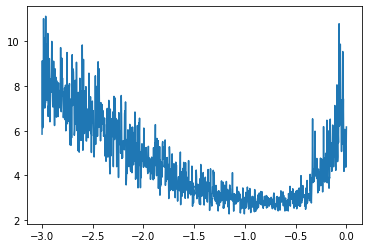

In [134]:
lri = []
lossi = []
for i in range(1000):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))
  # forward pass
  emb = C[X[ix]]                                  # input layer 
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
  logits = h @ W2 + b2                        # output layer
  loss = F.cross_entropy(logits, Y[ix])

  #print(loop, '\t', loss.item())
  loop += 1
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lrs[i]                   # get next learning rate
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])            # log exponent of learning rate
  lossi.append(loss.item())     # log corresponding log

plt.plot(lri, lossi)

## Splitting up the dataset
With big networks we tend to overfit our model (few training examples, many parameters) in other words, our network memorises our dataset. To stop this from happening, we split our dataset into three splits:
1. Training split (~80%)
2. Dev split / Validation split (~10%)
3. Test splits (~10%)

The (1) Training split is for training the dataset as above, (2) Dev split used for development over all the hyperparameters (eg. #neurons in hidden layer) of the model and (3) is for evaluating the performance of the model in the end.

If the loss with the training split and the loss with the test split are equal, we are **not** overfitting, but we are **underfitting**.

In [146]:
# build dataset

def build_dataset(words):
  block_size = 3          # number of characters used to predict the next one
  X, Y = [], []           # X: Input to the neural net, Y: Label for each example in X

  for w in words[:]:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]    # crop and append "rolling window"

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(f'X shape: {X.shape}, Y shape: {Y.shape}')
  return X, Y

# split dataset
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))    # 80% of words
n2 = int(0.9*len(words))    # 90% of words

Xtr, Ytr = build_dataset(words[:n1])      # Training split
Xdev, Ydev = build_dataset(words[n1:n2])  # Dev split
Xte, Yte = build_dataset(words[n2:])      # Test split

X shape: torch.Size([182625, 3]), Y shape: torch.Size([182625])
X shape: torch.Size([22655, 3]), Y shape: torch.Size([22655])
X shape: torch.Size([22866, 3]), Y shape: torch.Size([22866])


In [147]:
# Set up nn
g = torch.Generator().manual_seed(2147483647)
loop = 0

# embedded look up
C = torch.randn((27, 2), generator=g, requires_grad=True)

# hidden layer of nn
W1 = torch.randn((6, 100), generator=g, requires_grad=True)   # number of inputs (3 char x 2 dim embedding = 6), hyperparameter 100 neurons
b1 = torch.randn(100, requires_grad=True)

# output layer of nn
W2 = torch.randn((100, 27), generator=g, requires_grad=True)  # 27 output neurons for every char
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [148]:
# training with training split
print('loop:\tloss:')

for _ in range(10000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  # forward pass
  emb = C[Xtr[ix]]                                  # input layer 
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
  logits = h @ W2 + b2                        # output layer
  loss = F.cross_entropy(logits, Ytr[ix])

  #print(loop, '\t', loss.item())
  loop += 1
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loop, '\t', loss.item())

loop:	loss:
10000 	 2.426156520843506


In [149]:
# evaluate loss on dev split
emb = C[Xdev]                                  # input layer 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
logits = h @ W2 + b2                        # output layer
loss = F.cross_entropy(logits, Ydev)
print(f'loss: {loss.item()}')

loss: 2.4940316677093506


In [72]:
# sample from neural net model
for i in range(10):
  out = []
  ix = 0                                            # start token
  while True:
    # forward pass
    emb = C[X]                                  # input layer 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # hidden layer
    logits = h @ W2 + b2                        # output layer
    counts = logits.exp()                                   # [softmax] equivalent to dataset N
    p = counts / counts.sum(1, keepdims=True)
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()   # get "random" letter by probability
    out.append(itos[ix])
    if ix == 0:           # index is at the namebeginning again
      break
  print(''.join(out))

ValueError: ignored

In [75]:
p.shape

torch.Size([32, 27])